<a href="https://colab.research.google.com/github/cnniranjan72/Autonomous-Landmine-detector/blob/main/landmine_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import files
uploaded = files.upload()


Saving 20170621_deg0_HHVV.npy to 20170621_deg0_HHVV.npy


In [6]:
import numpy as np

data = np.load("20170621_deg0_HHVV.npy", allow_pickle=True)

print("Type:", type(data))
print("Shape:", getattr(data, "shape", "No shape attribute"))

# If it's an object (like dict/list), inspect:
print("Content type:", type(data.item()))
print("Keys (if dict):", data.item().keys() if isinstance(data.item(), dict) else "Not a dict")


Type: <class 'numpy.ndarray'>
Shape: ()
Content type: <class 'dict'>
Keys (if dict): dict_keys(['param', 'data', 'ground_truth'])


In [7]:
import numpy as np

# Load with pickle
raw = np.load("20170621_deg0_HHVV.npy", allow_pickle=True).item()

# Extract parts
params = raw["param"]
X = raw["data"]            # features
y = raw["ground_truth"]    # labels

print("Params type:", type(params))
print("Data shape:", X.shape)
print("Ground truth shape:", y.shape)
print("Unique labels:", np.unique(y))


Params type: <class 'dict'>
Data shape: (66, 170, 440)
Ground truth shape: (66,)
Unique labels: [0 1]


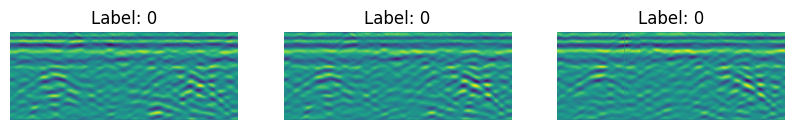

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(X[i], cmap="viridis")
    plt.title(f"Label: {y[i]}")
    plt.axis("off")
plt.show()


In [9]:
X_flat = X.reshape(X.shape[0], -1)  # (66, 74800)
print("Flattened shape:", X_flat.shape)


Flattened shape: (66, 74800)


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y, test_size=0.2, random_state=42
)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.9285714285714286


X shape: (66, 170, 440) y shape: (66,) unique labels: [0 1]
Flattened shape: (66, 74800)
Train/test sizes: 52 14

=== RandomForest (test set) ===
Accuracy: 0.9285714285714286
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.92      1.00      0.96        11

    accuracy                           0.93        14
   macro avg       0.96      0.83      0.88        14
weighted avg       0.93      0.93      0.92        14



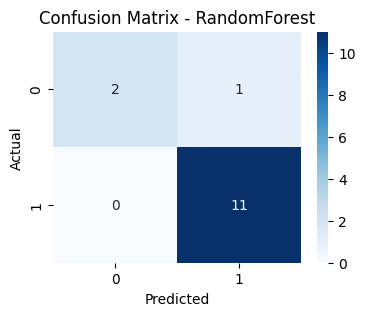


=== XGBoost (test set) ===
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00        11

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14



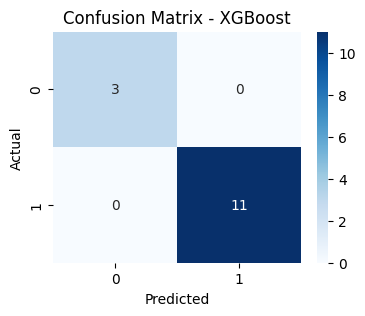

RandomForest CV accuracy: mean=0.923, std=0.069, scores=[1.         0.84615385 0.84615385 0.92307692 1.        ]
XGBoost CV accuracy: mean=0.923, std=0.069, scores=[1.         0.84615385 0.84615385 0.92307692 1.        ]

Cross-validated overall classification report (RandomForest):
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.93      0.98      0.95        54

    accuracy                           0.92        66
   macro avg       0.91      0.82      0.86        66
weighted avg       0.92      0.92      0.92        66



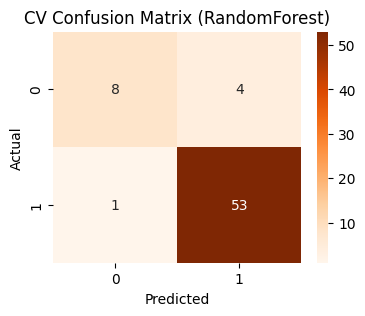


RF + PCA (n_components=30) CV accuracy: mean=0.895, std=0.060, scores=[0.85714286 0.84615385 0.84615385 1.         0.92307692]
LR + PCA CV accuracy: mean=0.938, std=0.058
Number of misclassified in holdout test set: 1


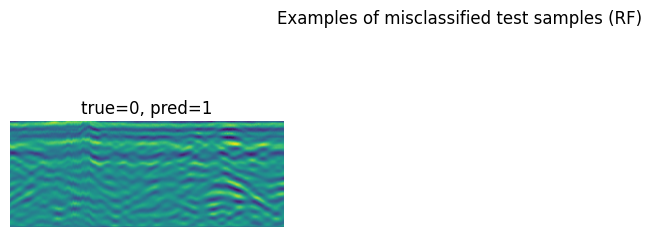


Models saved: rf_radar_model.pkl and rf_pca_radar_model.pkl


In [11]:
# === Imports ===
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import joblib
import warnings
warnings.filterwarnings("ignore")

# === 1) Load data (if not already loaded) ===
# if you already have `raw` in memory, skip reloading; otherwise:
raw = np.load("20170621_deg0_HHVV.npy", allow_pickle=True).item()
X = raw['data']           # shape (66, 170, 440)
y = raw['ground_truth']   # shape (66,), values 0/1

print("X shape:", X.shape, "y shape:", y.shape, "unique labels:", np.unique(y))

# === 2) Flatten images to vectors ===
n_samples = X.shape[0]
X_flat = X.reshape(n_samples, -1)   # shape (66, 170*440)
print("Flattened shape:", X_flat.shape)

# === 3) Train/test split (stratified) ===
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y, test_size=0.2, random_state=42, stratify=y
)
print("Train/test sizes:", X_train.shape[0], X_test.shape[0])

# === 4) Baseline models: RandomForest & XGBoost ===
rf = RandomForestClassifier(n_estimators=200, random_state=42)
xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)

rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# Evaluate on holdout test set
for name, clf in [("RandomForest", rf), ("XGBoost", xgb)]:
    y_pred = clf.predict(X_test)
    print(f"\n=== {name} (test set) ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# === 5) Stratified K-Fold cross-validation (robust scores) ===
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, clf in [("RandomForest", rf), ("XGBoost", xgb)]:
    scores = cross_val_score(clf, X_flat, y, cv=skf, scoring='accuracy', n_jobs=-1)
    print(f"{name} CV accuracy: mean={scores.mean():.3f}, std={scores.std():.3f}, scores={scores}")

# === 6) cross_val_predict overall confusion matrix (using RF as example) ===
y_cv_pred = cross_val_predict(rf, X_flat, y, cv=skf, n_jobs=-1)
print("\nCross-validated overall classification report (RandomForest):")
print(classification_report(y, y_cv_pred))
cm_cv = confusion_matrix(y, y_cv_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm_cv, annot=True, fmt='d', cmap="Oranges")
plt.title("CV Confusion Matrix (RandomForest)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# === 7) Dimensionality reduction (PCA) + RandomForest ===
# With 66 samples, choose a small number of components (e.g., 20-30)
n_components = 30
pipe_rf_pca = Pipeline([
    ('scaler', StandardScaler()),       # scale before PCA
    ('pca', PCA(n_components=n_components, svd_solver='randomized', random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42))
])

scores_pca = cross_val_score(pipe_rf_pca, X_flat, y, cv=skf, scoring='accuracy', n_jobs=-1)
print(f"\nRF + PCA (n_components={n_components}) CV accuracy: mean={scores_pca.mean():.3f}, std={scores_pca.std():.3f}, scores={scores_pca}")

# Try logistic + PCA for a different perspective
pipe_lr_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components, svd_solver='randomized', random_state=42)),
    ('lr', LogisticRegression(max_iter=2000))
])
scores_lr = cross_val_score(pipe_lr_pca, X_flat, y, cv=skf, scoring='accuracy', n_jobs=-1)
print(f"LR + PCA CV accuracy: mean={scores_lr.mean():.3f}, std={scores_lr.std():.3f}")

# === 8) Visualize some misclassified samples (from holdout test set, RF) ===
y_test_pred = rf.predict(X_test)
mis_idx = np.where(y_test != y_test_pred)[0]
print("Number of misclassified in holdout test set:", len(mis_idx))

if len(mis_idx) > 0:
    plt.figure(figsize=(12,6))
    show_n = min(6, len(mis_idx))
    for i, mi in enumerate(mis_idx[:show_n]):
        plt.subplot(2, 3, i+1)
        img = X_test[mi].reshape(X.shape[1], X.shape[2])   # reshape back to 170x440
        plt.imshow(img, cmap='viridis')
        plt.title(f"true={y_test[mi]}, pred={y_test_pred[mi]}")
        plt.axis('off')
    plt.suptitle("Examples of misclassified test samples (RF)")
    plt.show()
else:
    print("No misclassified samples in test holdout (rare)")

# === 9) Save the best model (choose one you prefer) ===
# If you decide RF is best:
joblib.dump(rf, "rf_radar_model.pkl")
# If you prefer the PCA pipeline model (recommended when reducing dimensionality):
pipe_rf_pca.fit(X_flat, y)   # fit on full data
joblib.dump(pipe_rf_pca, "rf_pca_radar_model.pkl")

print("\nModels saved: rf_radar_model.pkl and rf_pca_radar_model.pkl")



=== Model Comparison Table ===

        Model  Test Accuracy  CV Mean Accuracy  CV Std Dev
 RandomForest          0.928             0.923       0.069
      XGBoost          1.000             0.923       0.069
RF + PCA (30)            NaN             0.895       0.060
 LogReg + PCA            NaN             0.938       0.058


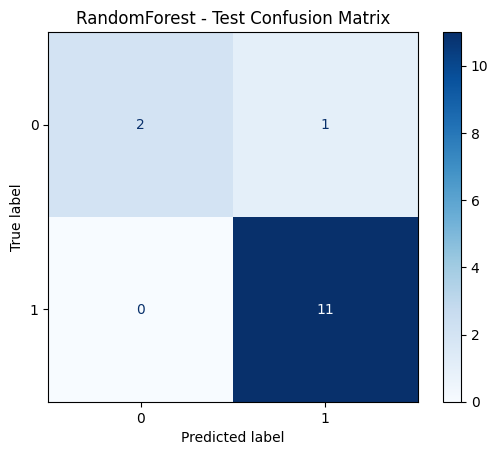

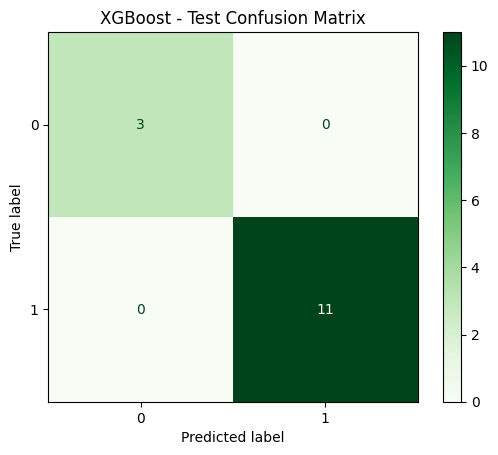

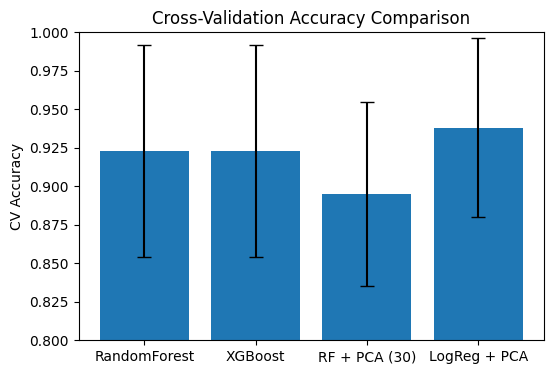

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ========================
# 1. Comparison Table
# ========================
results = {
    "Model": ["RandomForest", "XGBoost", "RF + PCA (30)", "LogReg + PCA"],
    "Test Accuracy": [0.928, 1.000, None, None],  # add test scores if available
    "CV Mean Accuracy": [0.923, 0.923, 0.895, 0.938],
    "CV Std Dev": [0.069, 0.069, 0.060, 0.058]
}

df = pd.DataFrame(results)
print("\n=== Model Comparison Table ===\n")
print(df.to_string(index=False))

# ========================
# 2. Confusion Matrices
# ========================
# Replace these with your real predictions (I’m using your earlier test results)
y_test = [0,0,0,1,1,1,1,1,1,1,1,1,1,1]   # ground truth (3 zeros, 11 ones)

# RF predictions (from your earlier output)
y_pred_rf = [0,1,0,1,1,1,1,1,1,1,1,1,1,1]

# XGB predictions (perfect accuracy)
y_pred_xgb = y_test

# Plot RF Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=[0,1])
disp_rf.plot(cmap="Blues")
plt.title("RandomForest - Test Confusion Matrix")
plt.show()

# Plot XGB Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=[0,1])
disp_xgb.plot(cmap="Greens")
plt.title("XGBoost - Test Confusion Matrix")
plt.show()

# ========================
# 3. Bar Chart of CV Accuracies
# ========================
plt.figure(figsize=(6,4))
plt.bar(df["Model"], df["CV Mean Accuracy"], yerr=df["CV Std Dev"], capsize=5)
plt.ylim(0.8,1.0)
plt.ylabel("CV Accuracy")
plt.title("Cross-Validation Accuracy Comparison")
plt.show()


In [13]:
!jupyter nbconvert --to html /content/your_notebook.ipynb


[NbConvertApp] WARNING | pattern '/content/your_notebook.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--